### Librerías

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install torchmetrics
!pip install torcheval

import os

import random
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torchsummary
import torch.optim as optim

from tqdm import tqdm

from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

from sklearn.metrics import precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt

from PIL import Image


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Cargar imágenes y sus targets

In [2]:
# Descargar y descromprimir el dataset de imágenes de fondo de ojo.
!gdown 1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
!unzip /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
#!unzip /content/preprocessed_images.zip -d ./preprocessed_images

# Descargar .csv que contiene los targets para cada imagen.
!gdown 1xe5Qzvqjzwlspm24um4sfnvY1RwL6c2h

Downloading...
From (original): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS
From (redirected): https://drive.google.com/uc?id=1Mcizi0JMfEtZE5dBzOgdOPXlUfMUCCAS&confirm=t&uuid=e0f762c8-ddcd-451c-87f4-056f1b8ebfaf
To: /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
100%|████████████████████████████████████████| 394M/394M [00:11<00:00, 34.0MB/s]
Archive:  /home/cristina/Documentos/ESPECIALIDAD_IA/vision2/Training/preprocessed_images.zip
  inflating: preprocessed_images/0_left.jpg  
  inflating: preprocessed_images/0_right.jpg  
  inflating: preprocessed_images/1_left.jpg  
  inflating: preprocessed_images/1_right.jpg  
  inflating: preprocessed_images/10_left.jpg  
  inflating: preprocessed_images/10_right.jpg  
  inflating: preprocessed_images/100_left.jpg  
  inflating: preprocessed_images/100_right.jpg  
  inflating: preprocessed_images/1005_right.jpg  
  inflating: preprocessed_images/1006_left.jpg  
  inflating: preprocessed_ima

### Instanciar dataset y dataloaders

In [29]:
class FundusDataset(Dataset):
    '''
    Custom Dataset para la carga de las imágenes de fondo de ojo con sus respectivos targets.
    Targets y sus significados:
    0 - Normal
    1 - Diabetes
    2 - Glaucoma
    3 - Cataratas
    4 - Degeneración macular asociada a la edad
    5 - Hipertensión
    6 - Miopía
    7 - Otras enfermedades o anormalidades
    '''
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.to_tensor = transforms.ToTensor()

        # Eliminar columnas redundantes
        self.df = self.df.drop(columns=['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'])

        # Convertir one-hot encoded 'target' a integer class labels
        self.df['target'] = self.df['target'].apply(lambda x: torch.argmax(torch.tensor(eval(x))))
        #class_mapping = {'N': 0, 'D': 1, 'G': 2, 'C': 3, 'A': 4, 'H': 5, 'M': 6, 'O': 7}
        #self.df['target'] = self.df['target'].map(class_mapping)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        
        img_name = os.path.join(self.root_dir, str(self.df.iloc[idx, self.df.columns.get_loc('filename')]))
        image = Image.open(img_name)
        #image = self.to_tensor(image)

        target_value = self.df.iloc[idx]['target']
        if not isinstance(target_value, torch.Tensor):
            label = torch.tensor(target_value).clone().detach()
        else:
            label = target_value.clone().detach()
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
     

    def _map_label_to_target(self, label):
        if label == '[\'N\']':
            return 0
            #return [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'D\']':
            return 1
            #return [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'G\']':
            return 2
            #return [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'C\']':
            return 3
            #return [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
        elif label == '[\'A\']':
            return 4
            #return [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
        elif label == '[\'H\']':
            return 5
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
        elif label == '[\'M\']':
            return 6
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        elif label == '[\'O\']':
            return 7
            #return [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
        else:
            raise Exception('Target desconocido')

class TransformedDataset(Dataset):
    def __init__(self, original_dataset, transform):
        self.original_dataset = original_dataset
        self.transform = transform

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        if not isinstance(image, torch.Tensor):  # Comprueba si la imagen es un tensor de PyTorch
            if self.transform:
                image = self.transform(image)
        return image, label  
# Leer el dataframe que contiene los targets para cada imagen.
full_df = pd.read_csv('full_df.csv')

# Instanciar el dataset.
dataset = FundusDataset(csv_file='full_df.csv', root_dir='preprocessed_images/')

# Dividir el dataset en entrenamiento y testing.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
train_dataset = TransformedDataset(train_dataset, transform=data_transforms)
test_dataset = TransformedDataset(test_dataset, transform=data_transforms)

# Instanciar dataloaders para ambos subsets.
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar shapes de los batches de entrenamiento.
train_features, train_labels = next(iter(train_dataloader))
print(f'Train feature batch shape: {train_features.size()}')
print(f'Train labels batch shape: {train_labels.size()}')

# Verificar shapes de los batches de testing.
test_features, test_labels = next(iter(test_dataloader))
print(f'Test feature batch shape: {test_features.size()}')
print(f'Test labels batch shape: {test_labels.size()}')




Train feature batch shape: torch.Size([32, 3, 224, 224])
Train labels batch shape: torch.Size([32])
Test feature batch shape: torch.Size([32, 3, 224, 224])
Test labels batch shape: torch.Size([32])


### Funciones de Entrenamiento

In [4]:
def train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, num_classes=8, early_stopping=False, patience=5):
    if early_stopping:
        best_loss = float('inf')
        no_improvement_count = 0

    accuracy = MulticlassAccuracy(num_classes=num_classes).to(device)
    precision = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    recall = MulticlassRecall(num_classes=num_classes, average='macro').to(device)

    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    test_losses = []
    test_accuracies = []
    test_precisions = []
    test_recalls = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
      
        
        for images, labels in tqdm(train_dataloader, desc=f'Training Epoch {epoch + 1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            

            accuracy.update(predicted, labels)
            precision.update(predicted, labels)
            recall.update(predicted, labels)

        train_loss = running_loss / len(train_dataloader)
        train_losses.append(train_loss)
        train_accuracy = accuracy.compute()
        train_accuracies.append(train_accuracy)
        train_precision = precision.compute()
        train_precisions.append(train_precision)
        train_recall = recall.compute()
        train_recalls.append(train_recall)

            #train_predictions.extend(predicted.cpu().tolist())
            #train_targets.extend(labels.cpu().tolist())



        print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}')

        # Evaluación del modelo en el conjunto de datos de prueba
        model.eval()
        test_correct = 0
        test_total = 0
        test_predictions = []
        test_targets = []
        with torch.no_grad():
            for images, labels in tqdm(test_dataloader, desc=f'Testing Epoch {epoch + 1}/{num_epochs}', unit='batch'):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
              

                accuracy.update(predicted, labels)
                precision.update(predicted, labels)
                recall.update(predicted, labels)

                #test_predictions.extend(predicted.cpu().tolist())
                #test_targets.extend(labels.cpu().tolist())
        test_loss = running_loss/len(test_dataloader)
        test_losses.append(test_loss)
        test_accuracy = accuracy.compute()
        test_accuracies.append(test_accuracy)
        test_precision = precision.compute()
        test_precisions.append(test_precision)
        test_recall = recall.compute()
        test_recalls.append(test_recall)

        print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}, Testing Precision: {test_precision:.4f}, Testing Recall: {test_recall:.4f}')

        if early_stopping:
            if test_loss < best_loss:
                best_loss = test_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print(f'No improvement for {patience} epochs. Early stopping...')
                break

    return train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls



In [5]:


def plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls):
    epochs = range(1, len(train_losses) + 1)


    # Convertir tensores a valores flotantes
    train_accuracies = [accuracy.item() for accuracy in train_accuracies]
    test_accuracies = [accuracy.item() for accuracy in test_accuracies]
    train_precisions = [precision.item() for precision in train_precisions]
    test_precisions = [precision.item() for precision in test_precisions]
    train_recalls = [recall.item() for recall in train_recalls]
    test_recalls = [recall.item() for recall in test_recalls]

  

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    # Plot loss
    axes[0, 0].plot(epochs, train_losses, label='Training Loss')
    axes[0, 0].plot(epochs, test_losses, label='Testing Loss')
    axes[0, 0].set_title('Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Plot accuracy
    axes[0, 1].plot(epochs, train_accuracies, label='Training Accuracy')
    axes[0, 1].plot(epochs, test_accuracies, label='Testing Accuracy')
    axes[0, 1].set_title('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Plot precision
    axes[1, 0].plot(epochs, train_precisions, label='Training Precision')
    axes[1, 0].plot(epochs, test_precisions, label='Testing Precision')
    axes[1, 0].set_title('Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()

    # Plot recall
    axes[1, 1].plot(epochs, train_recalls, label='Training Recall')
    axes[1, 1].plot(epochs, test_recalls, label='Testing Recall')
    axes[1, 1].set_title('Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()




### VGGNet16 con fine-tunning

In [6]:
# Definir el modelo VGGNet con fine-tuning
class VGGNetFineTuning(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetFineTuning, self).__init__()
        vgg = models.vgg16(models.VGG16_Weights.DEFAULT)
        for param in vgg.parameters():
            param.requires_grad = True
        # Modificar la capa de clasificación
        vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
        self.vgg = vgg

    def forward(self, x):
        return self.vgg(x)


In [7]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFineTuning(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)


/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training Epoch 1/100: 100%|████████████████| 160/160 [01:19<00:00,  2.01batch/s]


Training Loss: 1.7165, Training Accuracy: 0.1248, Training Precision: 0.1425, Training Recall: 0.1248


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 6.8660, Testing Accuracy: 0.1248, Testing Precision: 0.1420, Testing Recall: 0.1248


Training Epoch 2/100: 100%|████████████████| 160/160 [01:18<00:00,  2.03batch/s]


Training Loss: 1.5665, Training Accuracy: 0.1247, Training Precision: 0.1414, Training Recall: 0.1247


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.55batch/s]


Testing Loss: 6.2658, Testing Accuracy: 0.1247, Testing Precision: 0.1412, Testing Recall: 0.1247


Training Epoch 3/100: 100%|████████████████| 160/160 [01:18<00:00,  2.04batch/s]


Training Loss: 1.5675, Training Accuracy: 0.1248, Training Precision: 0.1412, Training Recall: 0.1248


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 6.2698, Testing Accuracy: 0.1248, Testing Precision: 0.1411, Testing Recall: 0.1248


Training Epoch 4/100: 100%|████████████████| 160/160 [01:18<00:00,  2.03batch/s]


Training Loss: 1.5637, Training Accuracy: 0.1249, Training Precision: 0.1412, Training Recall: 0.1249


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 6.2547, Testing Accuracy: 0.1249, Testing Precision: 0.1411, Testing Recall: 0.1249


Training Epoch 5/100: 100%|████████████████| 160/160 [01:22<00:00,  1.94batch/s]


Training Loss: 1.5666, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 6.2664, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 6/100: 100%|████████████████| 160/160 [01:21<00:00,  1.96batch/s]


Training Loss: 1.5608, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.23batch/s]


Testing Loss: 6.2433, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 7/100: 100%|████████████████| 160/160 [01:21<00:00,  1.96batch/s]


Training Loss: 1.5623, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 6.2493, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 8/100: 100%|████████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5597, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.24batch/s]


Testing Loss: 6.2389, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 9/100: 100%|████████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5606, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 6.2426, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 10/100: 100%|███████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5596, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 6.2383, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 11/100: 100%|███████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5574, Training Accuracy: 0.1249, Training Precision: 0.1410, Training Recall: 0.1249


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 6.2295, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 12/100: 100%|███████████████| 160/160 [01:22<00:00,  1.95batch/s]


Training Loss: 1.5606, Training Accuracy: 0.1249, Training Precision: 0.1409, Training Recall: 0.1249


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 6.2424, Testing Accuracy: 0.1249, Testing Precision: 0.1409, Testing Recall: 0.1249


Training Epoch 13/100: 100%|███████████████| 160/160 [01:19<00:00,  2.01batch/s]


Training Loss: 1.5589, Training Accuracy: 0.1249, Training Precision: 0.1409, Training Recall: 0.1249


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.54batch/s]


Testing Loss: 6.2356, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250


Training Epoch 14/100: 100%|███████████████| 160/160 [01:19<00:00,  2.02batch/s]


Training Loss: 1.5576, Training Accuracy: 0.1250, Training Precision: 0.1409, Training Recall: 0.1250


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.52batch/s]


Testing Loss: 6.2304, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250


Training Epoch 15/100: 100%|███████████████| 160/160 [01:19<00:00,  2.02batch/s]


Training Loss: 1.5584, Training Accuracy: 0.1250, Training Precision: 0.1409, Training Recall: 0.1250


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.56batch/s]


Testing Loss: 6.2337, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250


Training Epoch 16/100: 100%|███████████████| 160/160 [01:19<00:00,  2.02batch/s]


Training Loss: 1.5574, Training Accuracy: 0.1250, Training Precision: 0.1409, Training Recall: 0.1250


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.50batch/s]

Testing Loss: 6.2296, Testing Accuracy: 0.1250, Testing Precision: 0.1409, Testing Recall: 0.1250
No improvement for 5 epochs. Early stopping...


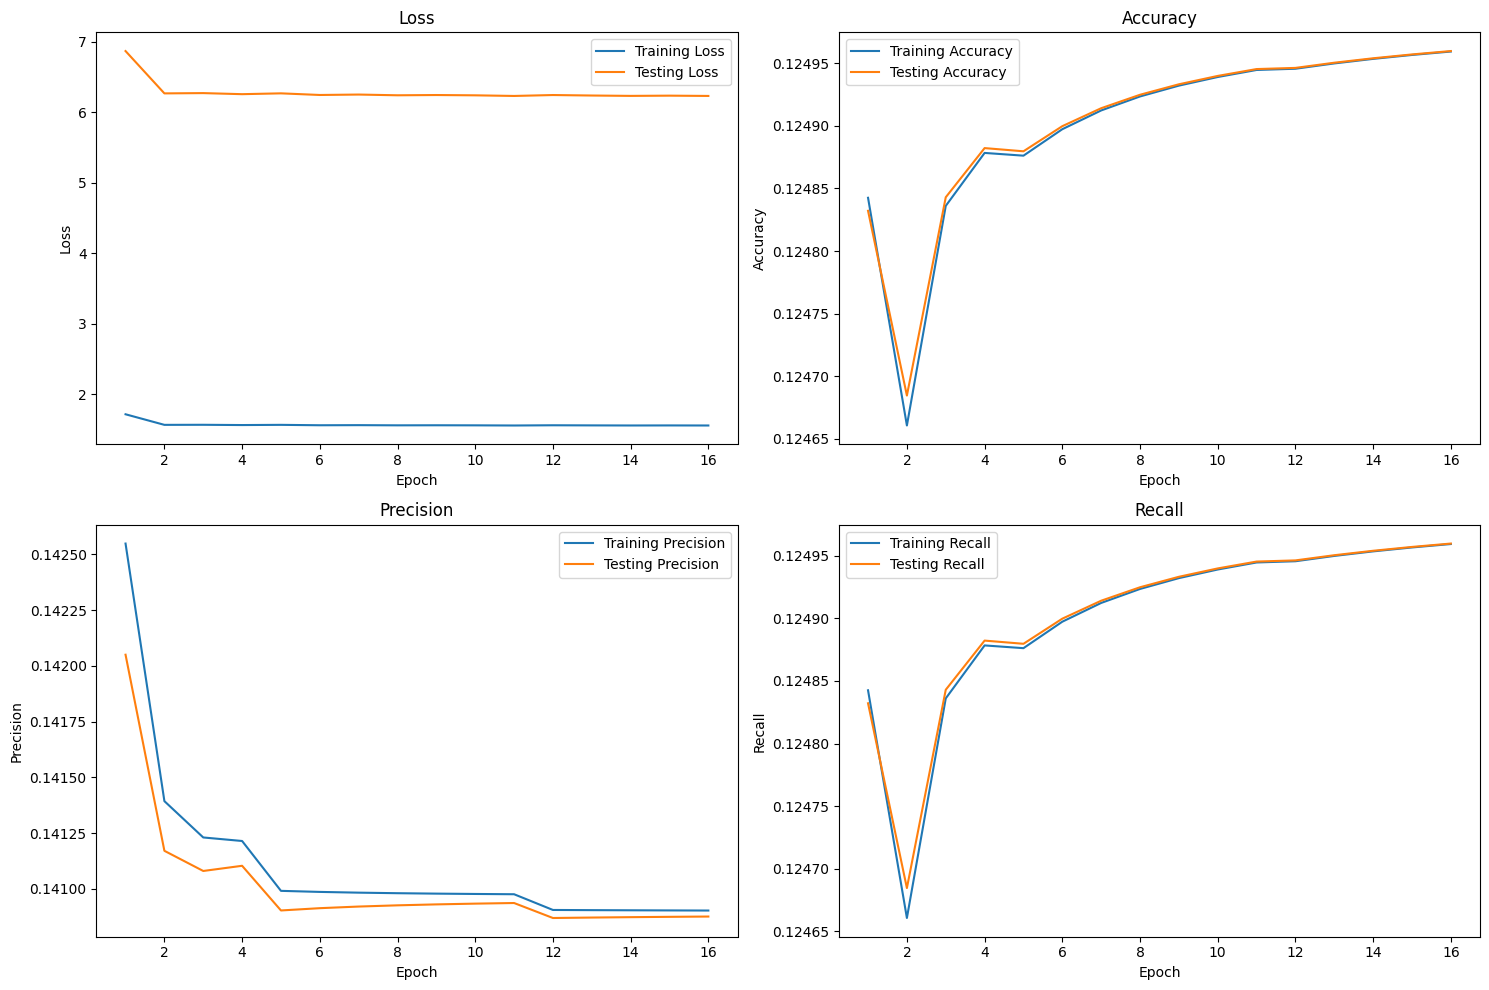

In [8]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [6]:
def compare_predictions(model, dataloader, device, class_names, num_samples=1):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(num_samples):
            expected_class = class_names[labels[i].item()]
            predicted_class = class_names[predicted[i].item()]
            print(f'Expected: {expected_class}, Predicted: {predicted_class}')

# Diccionario de mapeo de índices de clases a nombres de enfermedades
class_names = {
    0: 'Normal',
    1: 'Diabetes',
    2: 'Glaucoma',
    3: 'Cataratas',
    4: 'Degeneración macular asociada a la edad',
    5: 'Hipertensión',
    6: 'Miopía',
    7: 'Otras enfermedades o anormalidades'
}




In [11]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Glaucoma, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Normal


### VGGnet16 con feature extraction

In [7]:
torch.cuda.empty_cache() 


class VGGNetFeatureExtraction(nn.Module):
    def __init__(self, num_classes):
        super(VGGNetFeatureExtraction, self).__init__()
        vgg = models.vgg16(models.VGG16_Weights.DEFAULT)
        
        # Congelar todas las capas convolucionales
        for param in vgg.features.parameters():
            param.requires_grad = False
        
        # Extraer las capas convolucionales del VGG16
        self.features = vgg.features
        
        # Agregar una nueva capa completamente conectada para la clasificación
        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)  # Extracción de características
        x = torch.flatten(x, 1)  # Aplanar las características
        x = self.classifier(x)  # Clasificación
        return x

/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [8]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 1.7733, Training Accuracy: 0.2783, Training Precision: 0.2823, Training Recall: 0.2783


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 7.0930, Testing Accuracy: 0.2853, Testing Precision: 0.2971, Testing Recall: 0.2853


Training Epoch 2/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.3958, Training Accuracy: 0.3093, Training Precision: 0.3526, Training Recall: 0.3093


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 5.5831, Testing Accuracy: 0.3144, Testing Precision: 0.3586, Testing Recall: 0.3144


Training Epoch 3/100: 100%|████████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 1.3829, Training Accuracy: 0.3257, Training Precision: 0.3765, Training Recall: 0.3257


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 5.5318, Testing Accuracy: 0.3274, Testing Precision: 0.3785, Testing Recall: 0.3274


Training Epoch 4/100: 100%|████████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 1.3025, Training Accuracy: 0.3403, Training Precision: 0.4084, Training Recall: 0.3403


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 5.2101, Testing Accuracy: 0.3420, Testing Precision: 0.4083, Testing Recall: 0.3420


Training Epoch 5/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.2628, Training Accuracy: 0.3487, Training Precision: 0.4272, Training Recall: 0.3487


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 5.0510, Testing Accuracy: 0.3488, Testing Precision: 0.4285, Testing Recall: 0.3488


Training Epoch 6/100: 100%|████████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 1.2163, Training Accuracy: 0.3540, Training Precision: 0.4516, Training Recall: 0.3540


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 4.8651, Testing Accuracy: 0.3536, Testing Precision: 0.4523, Testing Recall: 0.3536


Training Epoch 7/100: 100%|████████████████| 160/160 [00:40<00:00,  3.97batch/s]


Training Loss: 1.1747, Training Accuracy: 0.3587, Training Precision: 0.4684, Training Recall: 0.3587


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 4.6987, Testing Accuracy: 0.3593, Testing Precision: 0.4675, Testing Recall: 0.3593


Training Epoch 8/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.1529, Training Accuracy: 0.3654, Training Precision: 0.4842, Training Recall: 0.3654


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 4.6118, Testing Accuracy: 0.3654, Testing Precision: 0.4845, Testing Recall: 0.3654


Training Epoch 9/100: 100%|████████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 1.1484, Training Accuracy: 0.3697, Training Precision: 0.4981, Training Recall: 0.3697


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 4.5937, Testing Accuracy: 0.3693, Testing Precision: 0.4987, Testing Recall: 0.3693


Training Epoch 10/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 1.0781, Training Accuracy: 0.3735, Training Precision: 0.5116, Training Recall: 0.3735


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 4.3124, Testing Accuracy: 0.3733, Testing Precision: 0.5115, Testing Recall: 0.3733


Training Epoch 11/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 1.0695, Training Accuracy: 0.3774, Training Precision: 0.5236, Training Recall: 0.3774


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 4.2781, Testing Accuracy: 0.3765, Testing Precision: 0.5229, Testing Recall: 0.3765


Training Epoch 12/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 1.0403, Training Accuracy: 0.3806, Training Precision: 0.5325, Training Recall: 0.3806


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 4.1614, Testing Accuracy: 0.3806, Testing Precision: 0.5317, Testing Recall: 0.3806


Training Epoch 13/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.9482, Training Accuracy: 0.3868, Training Precision: 0.5429, Training Recall: 0.3868


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.7929, Testing Accuracy: 0.3864, Testing Precision: 0.5427, Testing Recall: 0.3864


Training Epoch 14/100: 100%|███████████████| 160/160 [00:40<00:00,  3.98batch/s]


Training Loss: 0.9495, Training Accuracy: 0.3914, Training Precision: 0.5531, Training Recall: 0.3914


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.56batch/s]


Testing Loss: 3.7979, Testing Accuracy: 0.3913, Testing Precision: 0.5524, Testing Recall: 0.3913


Training Epoch 15/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.9552, Training Accuracy: 0.3945, Training Precision: 0.5591, Training Recall: 0.3945


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.8208, Testing Accuracy: 0.3941, Testing Precision: 0.5591, Testing Recall: 0.3941


Training Epoch 16/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 1.0189, Training Accuracy: 0.3962, Training Precision: 0.5626, Training Recall: 0.3962


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 4.0757, Testing Accuracy: 0.3955, Testing Precision: 0.5623, Testing Recall: 0.3955


Training Epoch 17/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 1.0099, Training Accuracy: 0.3980, Training Precision: 0.5670, Training Recall: 0.3980


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 4.0396, Testing Accuracy: 0.3976, Testing Precision: 0.5663, Testing Recall: 0.3976


Training Epoch 18/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.9479, Training Accuracy: 0.4006, Training Precision: 0.5704, Training Recall: 0.4006


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 3.7914, Testing Accuracy: 0.4001, Testing Precision: 0.5672, Testing Recall: 0.4001


Training Epoch 19/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.9205, Training Accuracy: 0.4028, Training Precision: 0.5724, Training Recall: 0.4028


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.6820, Testing Accuracy: 0.4022, Testing Precision: 0.5721, Testing Recall: 0.4022


Training Epoch 20/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.9165, Training Accuracy: 0.4044, Training Precision: 0.5776, Training Recall: 0.4044


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 3.6662, Testing Accuracy: 0.4042, Testing Precision: 0.5764, Testing Recall: 0.4042


Training Epoch 21/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.8855, Training Accuracy: 0.4084, Training Precision: 0.5832, Training Recall: 0.4084


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 3.5421, Testing Accuracy: 0.4078, Testing Precision: 0.5828, Testing Recall: 0.4078


Training Epoch 22/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.8644, Training Accuracy: 0.4119, Training Precision: 0.5879, Training Recall: 0.4119


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 3.4577, Testing Accuracy: 0.4115, Testing Precision: 0.5872, Testing Recall: 0.4115


Training Epoch 23/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.8807, Training Accuracy: 0.4147, Training Precision: 0.5924, Training Recall: 0.4147


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 3.5229, Testing Accuracy: 0.4145, Testing Precision: 0.5913, Testing Recall: 0.4145


Training Epoch 24/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.8614, Training Accuracy: 0.4184, Training Precision: 0.5969, Training Recall: 0.4184


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.4456, Testing Accuracy: 0.4178, Testing Precision: 0.5961, Testing Recall: 0.4178


Training Epoch 25/100: 100%|███████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.8574, Training Accuracy: 0.4208, Training Precision: 0.6010, Training Recall: 0.4208


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 3.4296, Testing Accuracy: 0.4204, Testing Precision: 0.6004, Testing Recall: 0.4204


Training Epoch 26/100: 100%|███████████████| 160/160 [00:40<00:00,  3.96batch/s]


Training Loss: 0.8009, Training Accuracy: 0.4244, Training Precision: 0.6065, Training Recall: 0.4244


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.2035, Testing Accuracy: 0.4243, Testing Precision: 0.6054, Testing Recall: 0.4243


Training Epoch 27/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8329, Training Accuracy: 0.4280, Training Precision: 0.6109, Training Recall: 0.4280


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 3.3317, Testing Accuracy: 0.4277, Testing Precision: 0.6096, Testing Recall: 0.4277


Training Epoch 28/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.8508, Training Accuracy: 0.4308, Training Precision: 0.6147, Training Recall: 0.4308


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 3.4033, Testing Accuracy: 0.4305, Testing Precision: 0.6139, Testing Recall: 0.4305


Training Epoch 29/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.7778, Training Accuracy: 0.4346, Training Precision: 0.6200, Training Recall: 0.4346


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 3.1112, Testing Accuracy: 0.4341, Testing Precision: 0.6193, Testing Recall: 0.4341


Training Epoch 30/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8092, Training Accuracy: 0.4375, Training Precision: 0.6244, Training Recall: 0.4375


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 3.2368, Testing Accuracy: 0.4370, Testing Precision: 0.6239, Testing Recall: 0.4370


Training Epoch 31/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.7771, Training Accuracy: 0.4407, Training Precision: 0.6297, Training Recall: 0.4407


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 3.1083, Testing Accuracy: 0.4403, Testing Precision: 0.6290, Testing Recall: 0.4403


Training Epoch 32/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.8475, Training Accuracy: 0.4426, Training Precision: 0.6329, Training Recall: 0.4426


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 3.3901, Testing Accuracy: 0.4421, Testing Precision: 0.6323, Testing Recall: 0.4421


Training Epoch 33/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.7921, Training Accuracy: 0.4451, Training Precision: 0.6370, Training Recall: 0.4451


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.1686, Testing Accuracy: 0.4448, Testing Precision: 0.6363, Testing Recall: 0.4448


Training Epoch 34/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8031, Training Accuracy: 0.4477, Training Precision: 0.6398, Training Recall: 0.4477


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 3.2125, Testing Accuracy: 0.4472, Testing Precision: 0.6395, Testing Recall: 0.4472


Training Epoch 35/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.8277, Training Accuracy: 0.4493, Training Precision: 0.6437, Training Recall: 0.4493


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.49batch/s]


Testing Loss: 3.3109, Testing Accuracy: 0.4488, Testing Precision: 0.6434, Testing Recall: 0.4488


Training Epoch 36/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.7585, Training Accuracy: 0.4519, Training Precision: 0.6456, Training Recall: 0.4519


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.0341, Testing Accuracy: 0.4515, Testing Precision: 0.6452, Testing Recall: 0.4515


Training Epoch 37/100: 100%|███████████████| 160/160 [00:40<00:00,  3.94batch/s]


Training Loss: 0.7632, Training Accuracy: 0.4541, Training Precision: 0.6491, Training Recall: 0.4541


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.45batch/s]


Testing Loss: 3.0530, Testing Accuracy: 0.4539, Testing Precision: 0.6486, Testing Recall: 0.4539


Training Epoch 38/100: 100%|███████████████| 160/160 [00:40<00:00,  3.95batch/s]


Training Loss: 0.8036, Training Accuracy: 0.4561, Training Precision: 0.6520, Training Recall: 0.4561


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 3.2144, Testing Accuracy: 0.4558, Testing Precision: 0.6516, Testing Recall: 0.4558


Training Epoch 39/100: 100%|███████████████| 160/160 [00:40<00:00,  3.93batch/s]


Training Loss: 0.7735, Training Accuracy: 0.4581, Training Precision: 0.6547, Training Recall: 0.4581


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 3.0942, Testing Accuracy: 0.4577, Testing Precision: 0.6543, Testing Recall: 0.4577


Training Epoch 40/100: 100%|███████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 0.8003, Training Accuracy: 0.4598, Training Precision: 0.6578, Training Recall: 0.4598


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 3.2011, Testing Accuracy: 0.4593, Testing Precision: 0.6574, Testing Recall: 0.4593


Training Epoch 41/100: 100%|███████████████| 160/160 [00:40<00:00,  3.92batch/s]


Training Loss: 0.8137, Training Accuracy: 0.4602, Training Precision: 0.6595, Training Recall: 0.4602


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]

Testing Loss: 3.2547, Testing Accuracy: 0.4597, Testing Precision: 0.6589, Testing Recall: 0.4597
No improvement for 5 epochs. Early stopping...


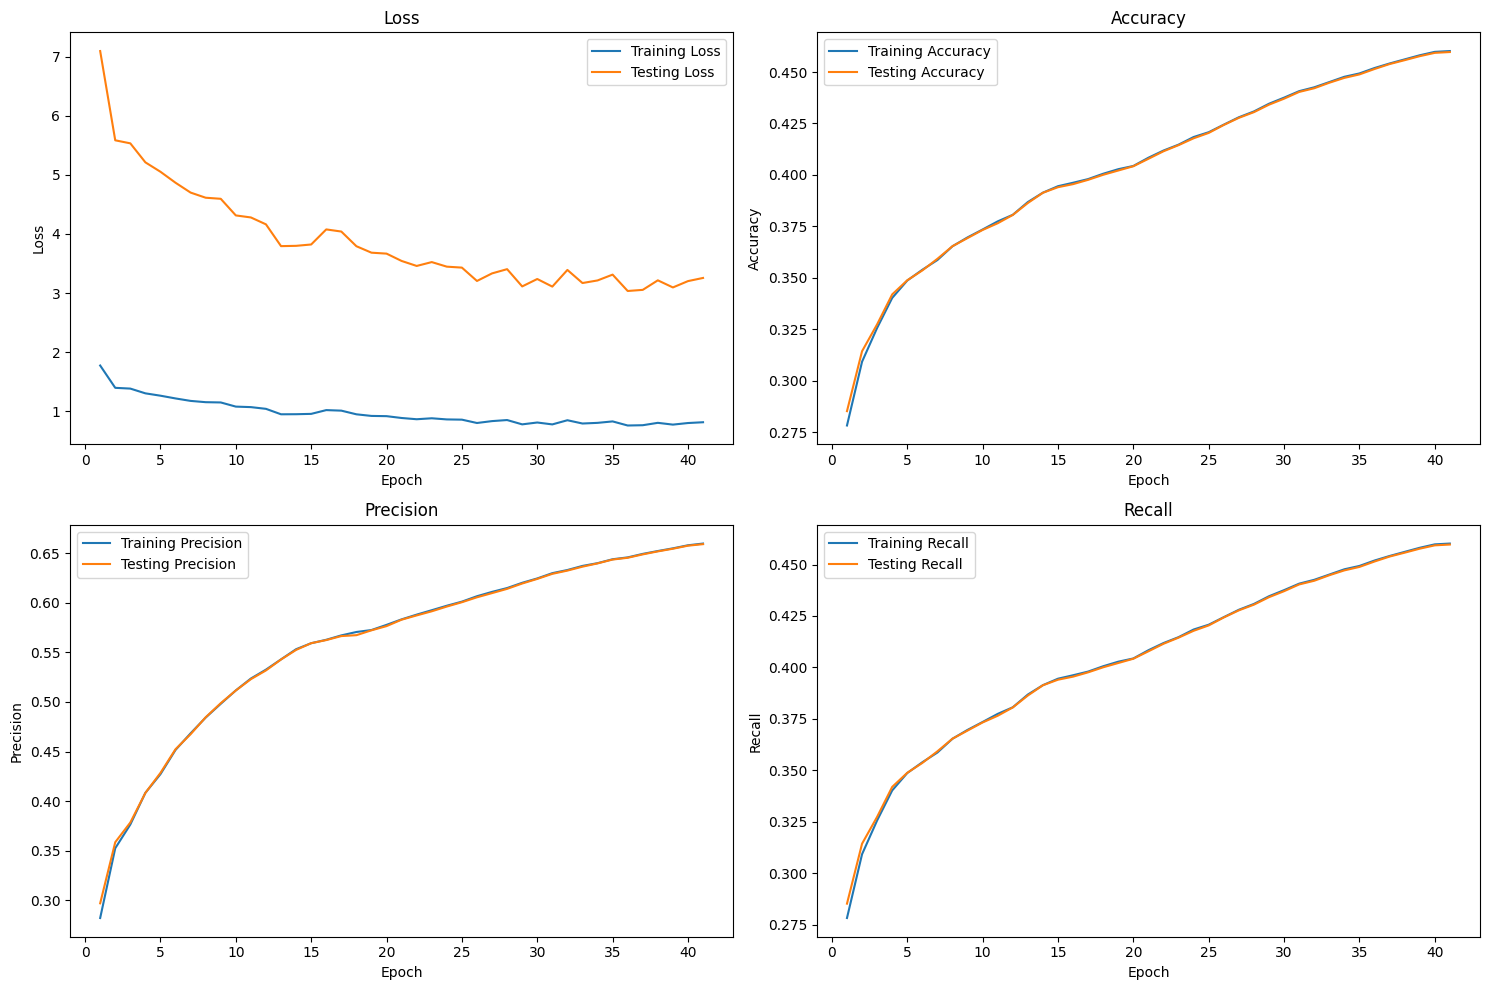

In [9]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [10]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Cataratas
Expected: Hipertensión, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Miopía
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Hipertensión


### VGGnet19 con fine tunning

In [20]:
torch.cuda.empty_cache()

class VGGNet19FineTuning(nn.Module):
    def __init__(self, num_classes):
        super(VGGNet19FineTuning, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        for param in vgg.parameters():
            param.requires_grad = True
        # Modificar la capa de clasificación
        vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
        self.vgg = vgg

    def forward(self, x):
        return self.vgg(x)


In [21]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNet19FineTuning(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100:  99%|███████████████▉| 159/160 [01:32<00:00,  1.69batch/s]/home/cristina/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 620.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/cristina/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 614.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/cristina/.local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 626.00 MiB. GPU  (Trigger

Training Loss: 1.6370, Training Accuracy: 0.1249, Training Precision: 0.1150, Training Recall: 0.1249


Testing Epoch 1/100:   0%|                            | 0/40 [00:00<?, ?batch/s]/home/cristina/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 394.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/home/cristina/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 786.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/home/cristina/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudn

Testing Loss: 6.5481, Testing Accuracy: 0.1250, Testing Precision: 0.1156, Testing Recall: 0.1250


Training Epoch 2/100: 100%|████████████████| 160/160 [01:35<00:00,  1.68batch/s]


Training Loss: 1.5878, Training Accuracy: 0.1248, Training Precision: 0.1143, Training Recall: 0.1248


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 6.3514, Testing Accuracy: 0.1248, Testing Precision: 0.1145, Testing Recall: 0.1248


Training Epoch 3/100: 100%|████████████████| 160/160 [01:35<00:00,  1.68batch/s]


Training Loss: 1.5850, Training Accuracy: 0.1248, Training Precision: 0.1140, Training Recall: 0.1248


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.67batch/s]


Testing Loss: 6.3399, Testing Accuracy: 0.1249, Testing Precision: 0.1141, Testing Recall: 0.1249


Training Epoch 4/100: 100%|████████████████| 160/160 [01:35<00:00,  1.68batch/s]


Training Loss: 1.5829, Training Accuracy: 0.1249, Training Precision: 0.1140, Training Recall: 0.1249


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.64batch/s]


Testing Loss: 6.3317, Testing Accuracy: 0.1249, Testing Precision: 0.1141, Testing Recall: 0.1249


Training Epoch 5/100: 100%|████████████████| 160/160 [01:35<00:00,  1.68batch/s]


Training Loss: 1.5809, Training Accuracy: 0.1249, Training Precision: 0.1140, Training Recall: 0.1249


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 6.3237, Testing Accuracy: 0.1249, Testing Precision: 0.1141, Testing Recall: 0.1249


Training Epoch 6/100: 100%|████████████████| 160/160 [01:35<00:00,  1.67batch/s]


Training Loss: 1.5809, Training Accuracy: 0.1249, Training Precision: 0.1141, Training Recall: 0.1249


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.60batch/s]


Testing Loss: 6.3235, Testing Accuracy: 0.1249, Testing Precision: 0.1142, Testing Recall: 0.1249


Training Epoch 7/100: 100%|████████████████| 160/160 [01:35<00:00,  1.67batch/s]


Training Loss: 1.5799, Training Accuracy: 0.1249, Training Precision: 0.1145, Training Recall: 0.1249


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.63batch/s]


Testing Loss: 6.3196, Testing Accuracy: 0.1249, Testing Precision: 0.1146, Testing Recall: 0.1249


Training Epoch 8/100: 100%|████████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5811, Training Accuracy: 0.1249, Training Precision: 0.1144, Training Recall: 0.1249


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 6.3243, Testing Accuracy: 0.1249, Testing Precision: 0.1145, Testing Recall: 0.1249


Training Epoch 9/100: 100%|████████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5771, Training Accuracy: 0.1250, Training Precision: 0.1144, Training Recall: 0.1250


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.59batch/s]


Testing Loss: 6.3083, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 10/100: 100%|███████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5795, Training Accuracy: 0.1250, Training Precision: 0.1144, Training Recall: 0.1250


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.59batch/s]


Testing Loss: 6.3179, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 11/100: 100%|███████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5810, Training Accuracy: 0.1250, Training Precision: 0.1145, Training Recall: 0.1250


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 6.3239, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 12/100: 100%|███████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5790, Training Accuracy: 0.1250, Training Precision: 0.1145, Training Recall: 0.1250


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.61batch/s]


Testing Loss: 6.3161, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 13/100: 100%|███████████████| 160/160 [01:36<00:00,  1.67batch/s]


Training Loss: 1.5793, Training Accuracy: 0.1250, Training Precision: 0.1145, Training Recall: 0.1250


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.60batch/s]


Testing Loss: 6.3173, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250


Training Epoch 14/100: 100%|███████████████| 160/160 [01:36<00:00,  1.66batch/s]


Training Loss: 1.5787, Training Accuracy: 0.1250, Training Precision: 0.1145, Training Recall: 0.1250


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.56batch/s]

Testing Loss: 6.3146, Testing Accuracy: 0.1250, Testing Precision: 0.1145, Testing Recall: 0.1250
No improvement for 5 epochs. Early stopping...


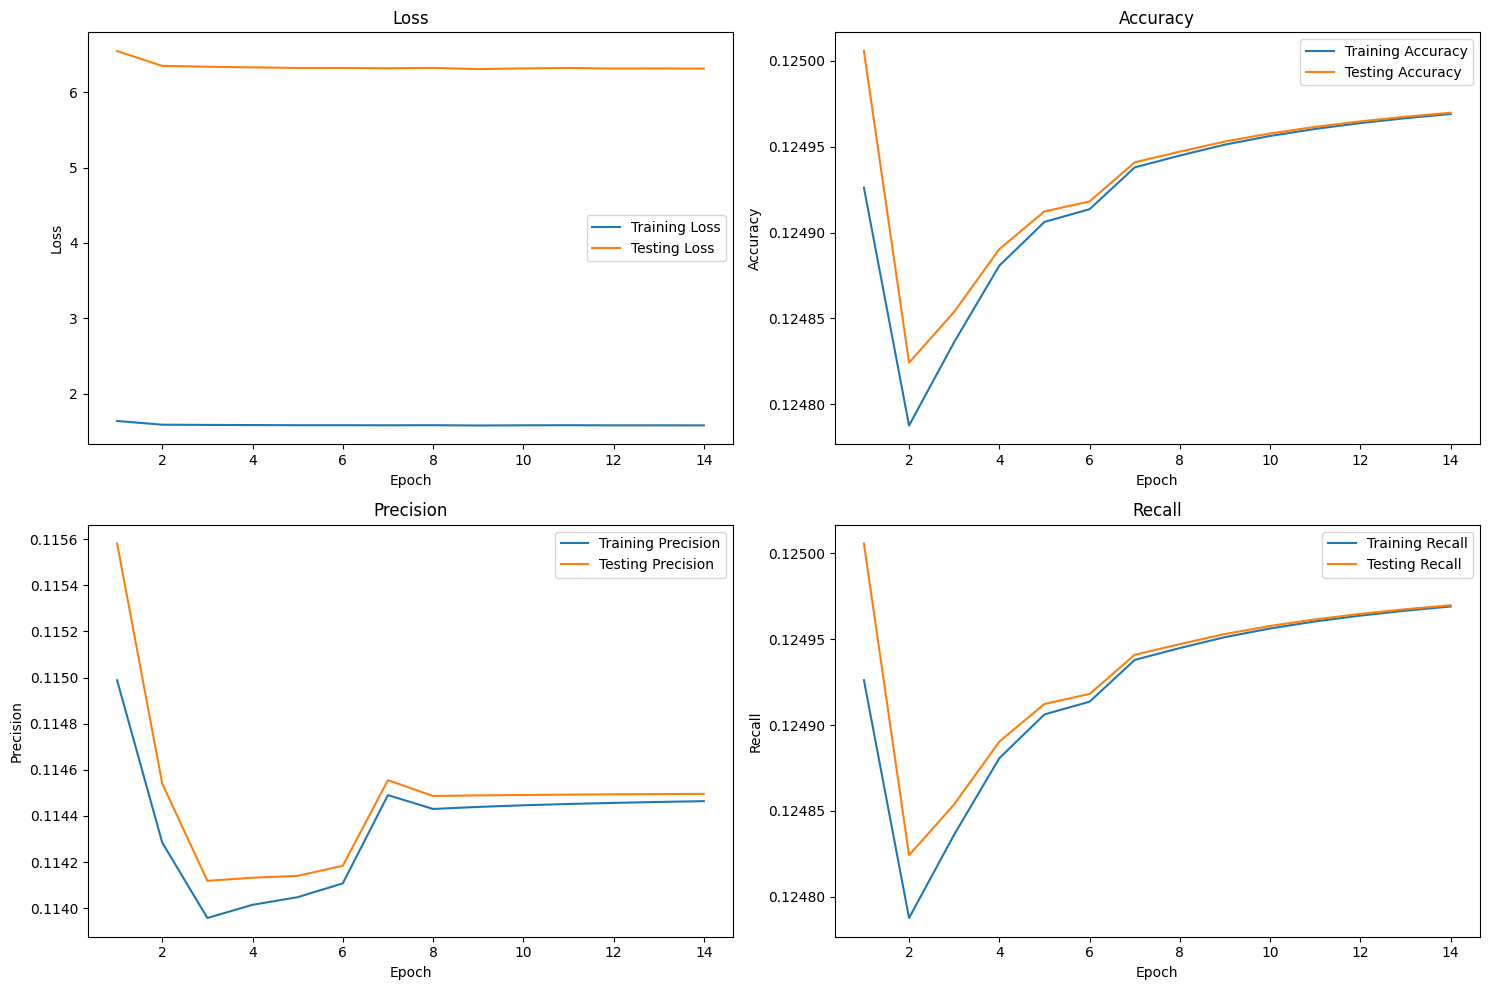

In [22]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [23]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal


In [24]:
torch.cuda.empty_cache()

class VGGNet19FeatureExtraction(nn.Module):
    def __init__(self, num_classes):
        super(VGGNet19FeatureExtraction, self).__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        
        # Congelar todas las capas convolucionales
        for param in vgg.features.parameters():
            param.requires_grad = False
        
        # Extraer las capas convolucionales del VGG19
        self.features = vgg.features
        
        # Agregar una nueva capa completamente conectada para la clasificación
        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)  # Extracción de características
        x = torch.flatten(x, 1)  # Aplanar las características
        x = self.classifier(x)  # Clasificación
        return x


In [25]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNet19FeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:48<00:00,  3.29batch/s]


Training Loss: 1.7857, Training Accuracy: 0.2822, Training Precision: 0.2851, Training Recall: 0.2822


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.69batch/s]


Testing Loss: 7.1430, Testing Accuracy: 0.2895, Testing Precision: 0.2878, Testing Recall: 0.2895


Training Epoch 2/100: 100%|████████████████| 160/160 [00:48<00:00,  3.29batch/s]


Training Loss: 1.3809, Training Accuracy: 0.3117, Training Precision: 0.3471, Training Recall: 0.3117


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 5.5236, Testing Accuracy: 0.3159, Testing Precision: 0.3539, Testing Recall: 0.3159


Training Epoch 3/100: 100%|████████████████| 160/160 [00:49<00:00,  3.26batch/s]


Training Loss: 1.3799, Training Accuracy: 0.3228, Training Precision: 0.3703, Training Recall: 0.3228


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.62batch/s]


Testing Loss: 5.5198, Testing Accuracy: 0.3196, Testing Precision: 0.3728, Testing Recall: 0.3196


Training Epoch 4/100: 100%|████████████████| 160/160 [00:49<00:00,  3.23batch/s]


Training Loss: 1.3007, Training Accuracy: 0.3300, Training Precision: 0.4032, Training Recall: 0.3300


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:11<00:00,  3.53batch/s]


Testing Loss: 5.2028, Testing Accuracy: 0.3311, Testing Precision: 0.4024, Testing Recall: 0.3311


Training Epoch 5/100: 100%|████████████████| 160/160 [00:49<00:00,  3.22batch/s]


Training Loss: 1.2449, Training Accuracy: 0.3375, Training Precision: 0.4157, Training Recall: 0.3375


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 4.9797, Testing Accuracy: 0.3386, Testing Precision: 0.4160, Testing Recall: 0.3386


Training Epoch 6/100: 100%|████████████████| 160/160 [00:48<00:00,  3.31batch/s]


Training Loss: 1.1792, Training Accuracy: 0.3437, Training Precision: 0.4250, Training Recall: 0.3437


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.68batch/s]


Testing Loss: 4.7167, Testing Accuracy: 0.3447, Testing Precision: 0.4264, Testing Recall: 0.3447


Training Epoch 7/100: 100%|████████████████| 160/160 [00:48<00:00,  3.33batch/s]


Training Loss: 1.1714, Training Accuracy: 0.3495, Training Precision: 0.4367, Training Recall: 0.3495


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.71batch/s]


Testing Loss: 4.6858, Testing Accuracy: 0.3500, Testing Precision: 0.4369, Testing Recall: 0.3500


Training Epoch 8/100: 100%|████████████████| 160/160 [00:48<00:00,  3.32batch/s]


Training Loss: 1.1808, Training Accuracy: 0.3537, Training Precision: 0.4509, Training Recall: 0.3537


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.67batch/s]


Testing Loss: 4.7231, Testing Accuracy: 0.3536, Testing Precision: 0.4508, Testing Recall: 0.3536


Training Epoch 9/100: 100%|████████████████| 160/160 [00:48<00:00,  3.33batch/s]


Training Loss: 1.1786, Training Accuracy: 0.3572, Training Precision: 0.4574, Training Recall: 0.3572


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:10<00:00,  3.66batch/s]


Testing Loss: 4.7144, Testing Accuracy: 0.3568, Testing Precision: 0.4575, Testing Recall: 0.3568


Training Epoch 10/100: 100%|███████████████| 160/160 [00:48<00:00,  3.32batch/s]


Training Loss: 1.1368, Training Accuracy: 0.3602, Training Precision: 0.4700, Training Recall: 0.3602


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.72batch/s]


Testing Loss: 4.5473, Testing Accuracy: 0.3598, Testing Precision: 0.4699, Testing Recall: 0.3598


Training Epoch 11/100: 100%|███████████████| 160/160 [00:48<00:00,  3.31batch/s]


Training Loss: 1.0921, Training Accuracy: 0.3631, Training Precision: 0.4819, Training Recall: 0.3631


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:11<00:00,  3.63batch/s]


Testing Loss: 4.3684, Testing Accuracy: 0.3624, Testing Precision: 0.4820, Testing Recall: 0.3624


Training Epoch 12/100: 100%|███████████████| 160/160 [00:48<00:00,  3.30batch/s]


Training Loss: 1.0906, Training Accuracy: 0.3658, Training Precision: 0.4923, Training Recall: 0.3658


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.64batch/s]


Testing Loss: 4.3624, Testing Accuracy: 0.3656, Testing Precision: 0.4926, Testing Recall: 0.3656


Training Epoch 13/100: 100%|███████████████| 160/160 [00:48<00:00,  3.29batch/s]


Training Loss: 1.0620, Training Accuracy: 0.3689, Training Precision: 0.5062, Training Recall: 0.3689


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.84batch/s]


Testing Loss: 4.2481, Testing Accuracy: 0.3685, Testing Precision: 0.5060, Testing Recall: 0.3685


Training Epoch 14/100: 100%|███████████████| 160/160 [00:45<00:00,  3.53batch/s]


Training Loss: 1.0460, Training Accuracy: 0.3719, Training Precision: 0.5174, Training Recall: 0.3719


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.01batch/s]


Testing Loss: 4.1838, Testing Accuracy: 0.3718, Testing Precision: 0.5167, Testing Recall: 0.3718


Training Epoch 15/100: 100%|███████████████| 160/160 [00:45<00:00,  3.52batch/s]


Training Loss: 1.1073, Training Accuracy: 0.3740, Training Precision: 0.5222, Training Recall: 0.3740


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 4.4290, Testing Accuracy: 0.3735, Testing Precision: 0.5221, Testing Recall: 0.3735


Training Epoch 16/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 1.0333, Training Accuracy: 0.3755, Training Precision: 0.5280, Training Recall: 0.3755


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.94batch/s]


Testing Loss: 4.1334, Testing Accuracy: 0.3752, Testing Precision: 0.5279, Testing Recall: 0.3752


Training Epoch 17/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 1.0033, Training Accuracy: 0.3780, Training Precision: 0.5335, Training Recall: 0.3780


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.81batch/s]


Testing Loss: 4.0131, Testing Accuracy: 0.3775, Testing Precision: 0.5338, Testing Recall: 0.3775


Training Epoch 18/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9853, Training Accuracy: 0.3803, Training Precision: 0.5430, Training Recall: 0.3803


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 3.9411, Testing Accuracy: 0.3801, Testing Precision: 0.5418, Testing Recall: 0.3801


Training Epoch 19/100: 100%|███████████████| 160/160 [00:46<00:00,  3.48batch/s]


Training Loss: 1.0073, Training Accuracy: 0.3824, Training Precision: 0.5482, Training Recall: 0.3824


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 4.0290, Testing Accuracy: 0.3822, Testing Precision: 0.5477, Testing Recall: 0.3822


Training Epoch 20/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 1.0222, Training Accuracy: 0.3840, Training Precision: 0.5557, Training Recall: 0.3840


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.85batch/s]


Testing Loss: 4.0888, Testing Accuracy: 0.3837, Testing Precision: 0.5551, Testing Recall: 0.3837


Training Epoch 21/100: 100%|███████████████| 160/160 [00:46<00:00,  3.48batch/s]


Training Loss: 0.9856, Training Accuracy: 0.3859, Training Precision: 0.5623, Training Recall: 0.3859


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 3.9423, Testing Accuracy: 0.3855, Testing Precision: 0.5611, Testing Recall: 0.3855


Training Epoch 22/100: 100%|███████████████| 160/160 [00:46<00:00,  3.46batch/s]


Training Loss: 1.0303, Training Accuracy: 0.3869, Training Precision: 0.5651, Training Recall: 0.3869


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 4.1212, Testing Accuracy: 0.3864, Testing Precision: 0.5643, Testing Recall: 0.3864


Training Epoch 23/100: 100%|███████████████| 160/160 [00:46<00:00,  3.45batch/s]


Training Loss: 0.9590, Training Accuracy: 0.3885, Training Precision: 0.5695, Training Recall: 0.3885


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 3.8360, Testing Accuracy: 0.3881, Testing Precision: 0.5684, Testing Recall: 0.3881


Training Epoch 24/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9593, Training Accuracy: 0.3898, Training Precision: 0.5748, Training Recall: 0.3898


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 3.8374, Testing Accuracy: 0.3894, Testing Precision: 0.5745, Testing Recall: 0.3894


Training Epoch 25/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9566, Training Accuracy: 0.3915, Training Precision: 0.5780, Training Recall: 0.3915


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.86batch/s]


Testing Loss: 3.8266, Testing Accuracy: 0.3910, Testing Precision: 0.5774, Testing Recall: 0.3910


Training Epoch 26/100: 100%|███████████████| 160/160 [00:46<00:00,  3.45batch/s]


Training Loss: 0.9672, Training Accuracy: 0.3927, Training Precision: 0.5824, Training Recall: 0.3927


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 3.8690, Testing Accuracy: 0.3921, Testing Precision: 0.5821, Testing Recall: 0.3921


Training Epoch 27/100: 100%|███████████████| 160/160 [00:46<00:00,  3.44batch/s]


Training Loss: 0.9313, Training Accuracy: 0.3941, Training Precision: 0.5860, Training Recall: 0.3941


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.84batch/s]


Testing Loss: 3.7251, Testing Accuracy: 0.3938, Testing Precision: 0.5857, Testing Recall: 0.3938


Training Epoch 28/100: 100%|███████████████| 160/160 [00:46<00:00,  3.45batch/s]


Training Loss: 0.9438, Training Accuracy: 0.3956, Training Precision: 0.5910, Training Recall: 0.3956


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 3.7751, Testing Accuracy: 0.3952, Testing Precision: 0.5905, Testing Recall: 0.3952


Training Epoch 29/100: 100%|███████████████| 160/160 [00:46<00:00,  3.46batch/s]


Training Loss: 0.9183, Training Accuracy: 0.3973, Training Precision: 0.5946, Training Recall: 0.3973


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 3.6733, Testing Accuracy: 0.3968, Testing Precision: 0.5940, Testing Recall: 0.3968


Training Epoch 30/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9187, Training Accuracy: 0.3987, Training Precision: 0.5992, Training Recall: 0.3987


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.82batch/s]


Testing Loss: 3.6750, Testing Accuracy: 0.3983, Testing Precision: 0.5985, Testing Recall: 0.3983


Training Epoch 31/100: 100%|███████████████| 160/160 [00:46<00:00,  3.47batch/s]


Training Loss: 0.9264, Training Accuracy: 0.3998, Training Precision: 0.6031, Training Recall: 0.3998


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.80batch/s]


Testing Loss: 3.7055, Testing Accuracy: 0.3996, Testing Precision: 0.6022, Testing Recall: 0.3996


Training Epoch 32/100: 100%|███████████████| 160/160 [00:45<00:00,  3.48batch/s]


Training Loss: 0.8896, Training Accuracy: 0.4015, Training Precision: 0.6064, Training Recall: 0.4015


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.74batch/s]


Testing Loss: 3.5583, Testing Accuracy: 0.4012, Testing Precision: 0.6051, Testing Recall: 0.4012


Training Epoch 33/100: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.9403, Training Accuracy: 0.4027, Training Precision: 0.6096, Training Recall: 0.4027


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]


Testing Loss: 3.7612, Testing Accuracy: 0.4024, Testing Precision: 0.6091, Testing Recall: 0.4024


Training Epoch 34/100: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.9722, Training Accuracy: 0.4037, Training Precision: 0.6124, Training Recall: 0.4037


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 3.8888, Testing Accuracy: 0.4031, Testing Precision: 0.6119, Testing Recall: 0.4031


Training Epoch 35/100: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.9380, Training Accuracy: 0.4043, Training Precision: 0.6151, Training Recall: 0.4043


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 3.7519, Testing Accuracy: 0.4040, Testing Precision: 0.6145, Testing Recall: 0.4040


Training Epoch 36/100: 100%|███████████████| 160/160 [00:45<00:00,  3.51batch/s]


Training Loss: 0.8812, Training Accuracy: 0.4058, Training Precision: 0.6197, Training Recall: 0.4058


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 3.5247, Testing Accuracy: 0.4054, Testing Precision: 0.6189, Testing Recall: 0.4054


Training Epoch 37/100: 100%|███████████████| 160/160 [00:45<00:00,  3.51batch/s]


Training Loss: 0.8532, Training Accuracy: 0.4072, Training Precision: 0.6232, Training Recall: 0.4072


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.83batch/s]


Testing Loss: 3.4128, Testing Accuracy: 0.4068, Testing Precision: 0.6226, Testing Recall: 0.4068


Training Epoch 38/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.8206, Training Accuracy: 0.4087, Training Precision: 0.6264, Training Recall: 0.4087


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.88batch/s]


Testing Loss: 3.2823, Testing Accuracy: 0.4085, Testing Precision: 0.6258, Testing Recall: 0.4085


Training Epoch 39/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.8779, Training Accuracy: 0.4100, Training Precision: 0.6282, Training Recall: 0.4100


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.86batch/s]


Testing Loss: 3.5116, Testing Accuracy: 0.4097, Testing Precision: 0.6276, Testing Recall: 0.4097


Training Epoch 40/100: 100%|███████████████| 160/160 [00:45<00:00,  3.51batch/s]


Training Loss: 0.8539, Training Accuracy: 0.4113, Training Precision: 0.6315, Training Recall: 0.4113


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.87batch/s]


Testing Loss: 3.4158, Testing Accuracy: 0.4109, Testing Precision: 0.6311, Testing Recall: 0.4109


Training Epoch 41/100: 100%|███████████████| 160/160 [00:45<00:00,  3.49batch/s]


Training Loss: 0.8597, Training Accuracy: 0.4123, Training Precision: 0.6352, Training Recall: 0.4123


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 3.4390, Testing Accuracy: 0.4120, Testing Precision: 0.6345, Testing Recall: 0.4120


Training Epoch 42/100: 100%|███████████████| 160/160 [00:45<00:00,  3.48batch/s]


Training Loss: 0.8299, Training Accuracy: 0.4135, Training Precision: 0.6385, Training Recall: 0.4135


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.89batch/s]


Testing Loss: 3.3198, Testing Accuracy: 0.4132, Testing Precision: 0.6382, Testing Recall: 0.4132


Training Epoch 43/100: 100%|███████████████| 160/160 [00:45<00:00,  3.50batch/s]


Training Loss: 0.8281, Training Accuracy: 0.4146, Training Precision: 0.6413, Training Recall: 0.4146


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:10<00:00,  3.92batch/s]

Testing Loss: 3.3125, Testing Accuracy: 0.4143, Testing Precision: 0.6410, Testing Recall: 0.4143
No improvement for 5 epochs. Early stopping...


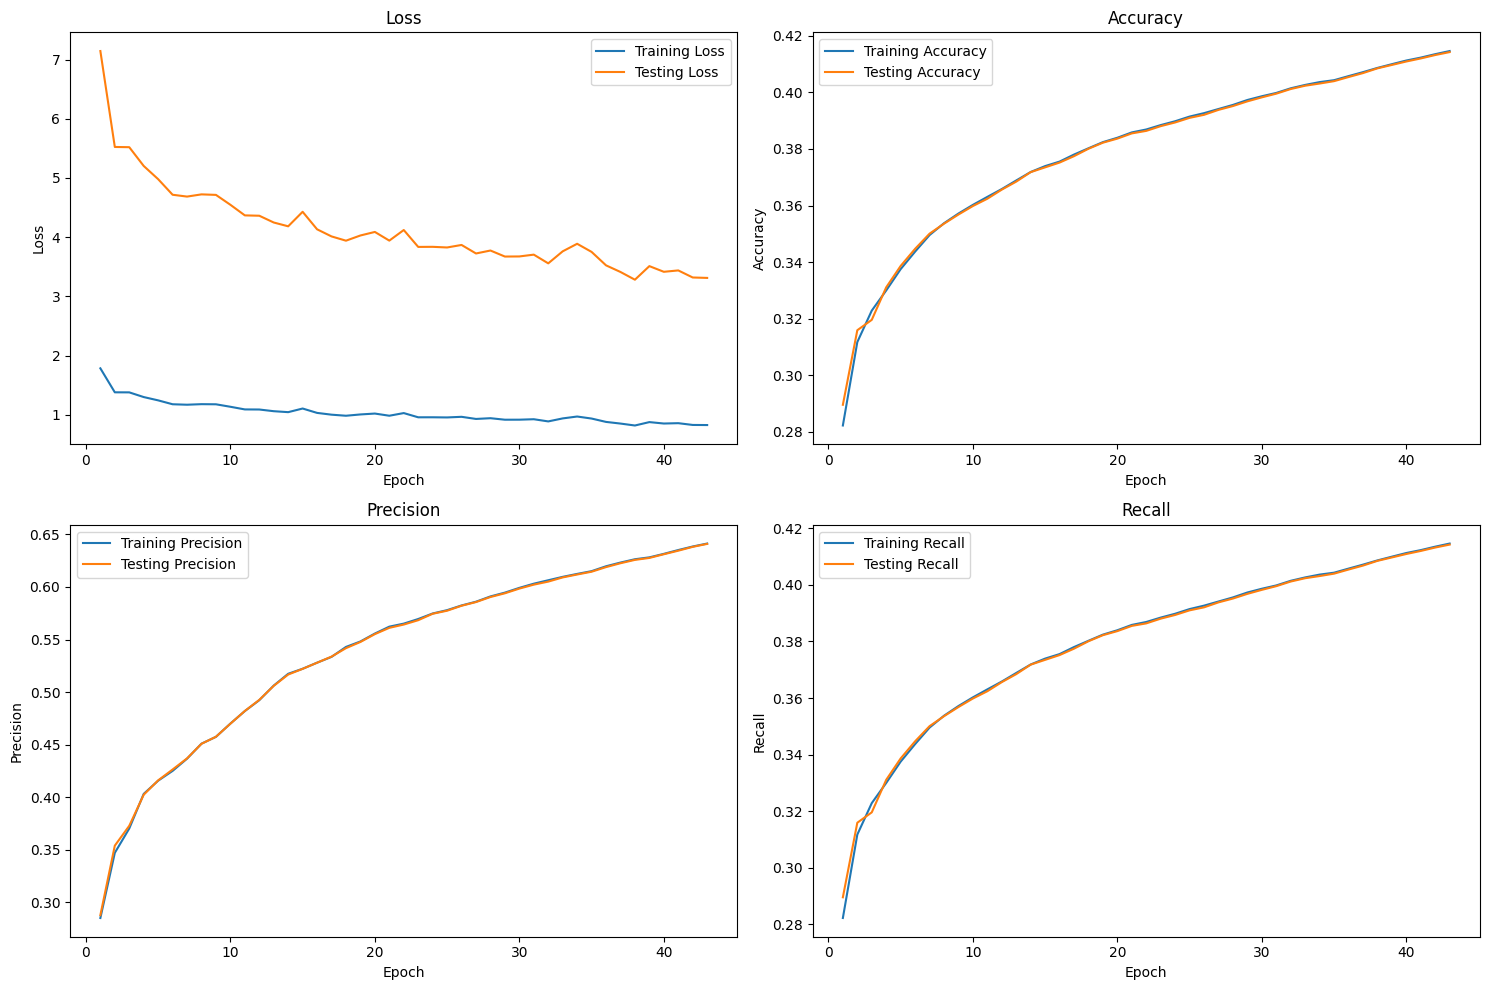

In [26]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [27]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Miopía, Predicted: Miopía
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Cataratas, Predicted: Cataratas
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Miopía, Predicted: Miopía
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal


### VGG16 con feature extraction con data augmentation

De los entrenamientos anteriores, el mejor encontrado corresponde a VGG16 con feature extraction, en este caso se agrega un entrenamiento con data augmentation para evaluar su performance.

In [30]:
torch.cuda.empty_cache()

# Definir transformaciones de data augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Aplicar transformaciones de data augmentation solo al conjunto de datos de entrenamiento
train_dataset_augmented = TransformedDataset(train_dataset, transform=train_transform)

# Instanciar dataloader para el conjunto de datos de entrenamiento aumentado
train_dataloader_augmented = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

# Verificar shapes de los batches de entrenamiento aumentados
train_features_augmented, train_labels_augmented = next(iter(train_dataloader_augmented))
print(f'Train feature batch shape after augmentation: {train_features_augmented.size()}')
print(f'Train labels batch shape after augmentation: {train_labels_augmented.size()}')


Train feature batch shape after augmentation: torch.Size([32, 3, 224, 224])
Train labels batch shape after augmentation: torch.Size([32])


In [31]:
num_epochs = 100
learning_rate = 0.001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

/home/cristina/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training Epoch 1/100: 100%|████████████████| 160/160 [00:42<00:00,  3.78batch/s]


Training Loss: 1.6938, Training Accuracy: 0.2775, Training Precision: 0.2809, Training Recall: 0.2775


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 6.7751, Testing Accuracy: 0.2644, Testing Precision: 0.2918, Testing Recall: 0.2644


Training Epoch 2/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 1.3783, Training Accuracy: 0.2971, Training Precision: 0.3560, Training Recall: 0.2971


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 5.5131, Testing Accuracy: 0.3028, Testing Precision: 0.3585, Testing Recall: 0.3028


Training Epoch 3/100: 100%|████████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 1.3267, Training Accuracy: 0.3187, Training Precision: 0.3737, Training Recall: 0.3187


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 5.3069, Testing Accuracy: 0.3213, Testing Precision: 0.3680, Testing Recall: 0.3213


Training Epoch 4/100: 100%|████████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 1.2837, Training Accuracy: 0.3342, Training Precision: 0.3943, Training Recall: 0.3342


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 5.1349, Testing Accuracy: 0.3351, Testing Precision: 0.3954, Testing Recall: 0.3351


Training Epoch 5/100: 100%|████████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 1.2660, Training Accuracy: 0.3419, Training Precision: 0.4039, Training Recall: 0.3419


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.25batch/s]


Testing Loss: 5.0639, Testing Accuracy: 0.3427, Testing Precision: 0.4046, Testing Recall: 0.3427


Training Epoch 6/100: 100%|████████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 1.1803, Training Accuracy: 0.3497, Training Precision: 0.4296, Training Recall: 0.3497


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 4.7213, Testing Accuracy: 0.3497, Testing Precision: 0.4310, Testing Recall: 0.3497


Training Epoch 7/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 1.1594, Training Accuracy: 0.3547, Training Precision: 0.4508, Training Recall: 0.3547


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 4.6376, Testing Accuracy: 0.3545, Testing Precision: 0.4505, Testing Recall: 0.3545


Training Epoch 8/100: 100%|████████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 1.1169, Training Accuracy: 0.3599, Training Precision: 0.4721, Training Recall: 0.3599


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 4.4674, Testing Accuracy: 0.3603, Testing Precision: 0.4718, Testing Recall: 0.3603


Training Epoch 9/100: 100%|████████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 1.0796, Training Accuracy: 0.3673, Training Precision: 0.4948, Training Recall: 0.3673


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 4.3184, Testing Accuracy: 0.3663, Testing Precision: 0.4951, Testing Recall: 0.3663


Training Epoch 10/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 1.0954, Training Accuracy: 0.3697, Training Precision: 0.5092, Training Recall: 0.3697


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 4.3816, Testing Accuracy: 0.3690, Testing Precision: 0.5096, Testing Recall: 0.3690


Training Epoch 11/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 1.0144, Training Accuracy: 0.3737, Training Precision: 0.5269, Training Recall: 0.3737


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.11batch/s]


Testing Loss: 4.0575, Testing Accuracy: 0.3741, Testing Precision: 0.5284, Testing Recall: 0.3741


Training Epoch 12/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.9844, Training Accuracy: 0.3797, Training Precision: 0.5440, Training Recall: 0.3797


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 3.9376, Testing Accuracy: 0.3794, Testing Precision: 0.5438, Testing Recall: 0.3794


Training Epoch 13/100: 100%|███████████████| 160/160 [00:41<00:00,  3.81batch/s]


Training Loss: 1.0222, Training Accuracy: 0.3840, Training Precision: 0.5521, Training Recall: 0.3840


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 4.0887, Testing Accuracy: 0.3838, Testing Precision: 0.5516, Testing Recall: 0.3838


Training Epoch 14/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.9643, Training Accuracy: 0.3877, Training Precision: 0.5572, Training Recall: 0.3877


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.48batch/s]


Testing Loss: 3.8572, Testing Accuracy: 0.3870, Testing Precision: 0.5566, Testing Recall: 0.3870


Training Epoch 15/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.9278, Training Accuracy: 0.3926, Training Precision: 0.5658, Training Recall: 0.3926


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 3.7111, Testing Accuracy: 0.3922, Testing Precision: 0.5653, Testing Recall: 0.3922


Training Epoch 16/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.9253, Training Accuracy: 0.3961, Training Precision: 0.5748, Training Recall: 0.3961


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 3.7014, Testing Accuracy: 0.3955, Testing Precision: 0.5742, Testing Recall: 0.3955


Training Epoch 17/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.8875, Training Accuracy: 0.4002, Training Precision: 0.5822, Training Recall: 0.4002


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 3.5499, Testing Accuracy: 0.3998, Testing Precision: 0.5818, Testing Recall: 0.3998


Training Epoch 18/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.8774, Training Accuracy: 0.4034, Training Precision: 0.5895, Training Recall: 0.4034


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.43batch/s]


Testing Loss: 3.5095, Testing Accuracy: 0.4031, Testing Precision: 0.5883, Testing Recall: 0.4031


Training Epoch 19/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.8559, Training Accuracy: 0.4069, Training Precision: 0.5963, Training Recall: 0.4069


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 3.4237, Testing Accuracy: 0.4065, Testing Precision: 0.5957, Testing Recall: 0.4065


Training Epoch 20/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.8418, Training Accuracy: 0.4119, Training Precision: 0.6023, Training Recall: 0.4119


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.3671, Testing Accuracy: 0.4114, Testing Precision: 0.6023, Testing Recall: 0.4114


Training Epoch 21/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.8631, Training Accuracy: 0.4152, Training Precision: 0.6084, Training Recall: 0.4152


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 3.4523, Testing Accuracy: 0.4149, Testing Precision: 0.6079, Testing Recall: 0.4149


Training Epoch 22/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.8444, Training Accuracy: 0.4185, Training Precision: 0.6143, Training Recall: 0.4185


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.3777, Testing Accuracy: 0.4181, Testing Precision: 0.6135, Testing Recall: 0.4181


Training Epoch 23/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.8195, Training Accuracy: 0.4209, Training Precision: 0.6196, Training Recall: 0.4209


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 3.2782, Testing Accuracy: 0.4203, Testing Precision: 0.6190, Testing Recall: 0.4203


Training Epoch 24/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.8164, Training Accuracy: 0.4230, Training Precision: 0.6246, Training Recall: 0.4230


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 3.2655, Testing Accuracy: 0.4227, Testing Precision: 0.6242, Testing Recall: 0.4227


Training Epoch 25/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.8529, Training Accuracy: 0.4246, Training Precision: 0.6290, Training Recall: 0.4246


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.4116, Testing Accuracy: 0.4241, Testing Precision: 0.6286, Testing Recall: 0.4241


Training Epoch 26/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.8090, Training Accuracy: 0.4268, Training Precision: 0.6331, Training Recall: 0.4268


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 3.2358, Testing Accuracy: 0.4263, Testing Precision: 0.6327, Testing Recall: 0.4263


Training Epoch 27/100: 100%|███████████████| 160/160 [00:42<00:00,  3.74batch/s]


Training Loss: 0.8173, Training Accuracy: 0.4287, Training Precision: 0.6372, Training Recall: 0.4287


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.22batch/s]


Testing Loss: 3.2693, Testing Accuracy: 0.4281, Testing Precision: 0.6368, Testing Recall: 0.4281


Training Epoch 28/100: 100%|███████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.8166, Training Accuracy: 0.4304, Training Precision: 0.6418, Training Recall: 0.4304


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 3.2666, Testing Accuracy: 0.4297, Testing Precision: 0.6410, Testing Recall: 0.4297


Training Epoch 29/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.7836, Training Accuracy: 0.4321, Training Precision: 0.6457, Training Recall: 0.4321


Testing Epoch 29/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.34batch/s]


Testing Loss: 3.1342, Testing Accuracy: 0.4316, Testing Precision: 0.6450, Testing Recall: 0.4316


Training Epoch 30/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.8004, Training Accuracy: 0.4338, Training Precision: 0.6489, Training Recall: 0.4338


Testing Epoch 30/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.29batch/s]


Testing Loss: 3.2015, Testing Accuracy: 0.4333, Testing Precision: 0.6486, Testing Recall: 0.4333


Training Epoch 31/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.7919, Training Accuracy: 0.4357, Training Precision: 0.6528, Training Recall: 0.4357


Testing Epoch 31/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 3.1675, Testing Accuracy: 0.4352, Testing Precision: 0.6523, Testing Recall: 0.4352


Training Epoch 32/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.8440, Training Accuracy: 0.4376, Training Precision: 0.6562, Training Recall: 0.4376


Testing Epoch 32/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]


Testing Loss: 3.3759, Testing Accuracy: 0.4370, Testing Precision: 0.6561, Testing Recall: 0.4370


Training Epoch 33/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7735, Training Accuracy: 0.4393, Training Precision: 0.6594, Training Recall: 0.4393


Testing Epoch 33/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 3.0941, Testing Accuracy: 0.4388, Testing Precision: 0.6589, Testing Recall: 0.4388


Training Epoch 34/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.7810, Training Accuracy: 0.4413, Training Precision: 0.6607, Training Recall: 0.4413


Testing Epoch 34/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 3.1238, Testing Accuracy: 0.4409, Testing Precision: 0.6602, Testing Recall: 0.4409


Training Epoch 35/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7995, Training Accuracy: 0.4433, Training Precision: 0.6633, Training Recall: 0.4433


Testing Epoch 35/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 3.1980, Testing Accuracy: 0.4429, Testing Precision: 0.6630, Testing Recall: 0.4429


Training Epoch 36/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.7670, Training Accuracy: 0.4454, Training Precision: 0.6661, Training Recall: 0.4454


Testing Epoch 36/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.21batch/s]


Testing Loss: 3.0679, Testing Accuracy: 0.4450, Testing Precision: 0.6656, Testing Recall: 0.4450


Training Epoch 37/100: 100%|███████████████| 160/160 [00:42<00:00,  3.75batch/s]


Training Loss: 0.7596, Training Accuracy: 0.4476, Training Precision: 0.6689, Training Recall: 0.4476


Testing Epoch 37/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 3.0385, Testing Accuracy: 0.4473, Testing Precision: 0.6687, Testing Recall: 0.4473


Training Epoch 38/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7300, Training Accuracy: 0.4499, Training Precision: 0.6723, Training Recall: 0.4499


Testing Epoch 38/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.31batch/s]


Testing Loss: 2.9199, Testing Accuracy: 0.4494, Testing Precision: 0.6718, Testing Recall: 0.4494


Training Epoch 39/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.7435, Training Accuracy: 0.4518, Training Precision: 0.6751, Training Recall: 0.4518


Testing Epoch 39/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 2.9741, Testing Accuracy: 0.4514, Testing Precision: 0.6748, Testing Recall: 0.4514


Training Epoch 40/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.7426, Training Accuracy: 0.4539, Training Precision: 0.6782, Training Recall: 0.4539


Testing Epoch 40/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 2.9703, Testing Accuracy: 0.4533, Testing Precision: 0.6778, Testing Recall: 0.4533


Training Epoch 41/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7320, Training Accuracy: 0.4555, Training Precision: 0.6809, Training Recall: 0.4555


Testing Epoch 41/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.28batch/s]


Testing Loss: 2.9282, Testing Accuracy: 0.4551, Testing Precision: 0.6803, Testing Recall: 0.4551


Training Epoch 42/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7633, Training Accuracy: 0.4565, Training Precision: 0.6832, Training Recall: 0.4565


Testing Epoch 42/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.30batch/s]


Testing Loss: 3.0534, Testing Accuracy: 0.4561, Testing Precision: 0.6829, Testing Recall: 0.4561


Training Epoch 43/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.7428, Training Accuracy: 0.4579, Training Precision: 0.6854, Training Recall: 0.4579


Testing Epoch 43/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.35batch/s]

Testing Loss: 2.9713, Testing Accuracy: 0.4575, Testing Precision: 0.6852, Testing Recall: 0.4575
No improvement for 5 epochs. Early stopping...


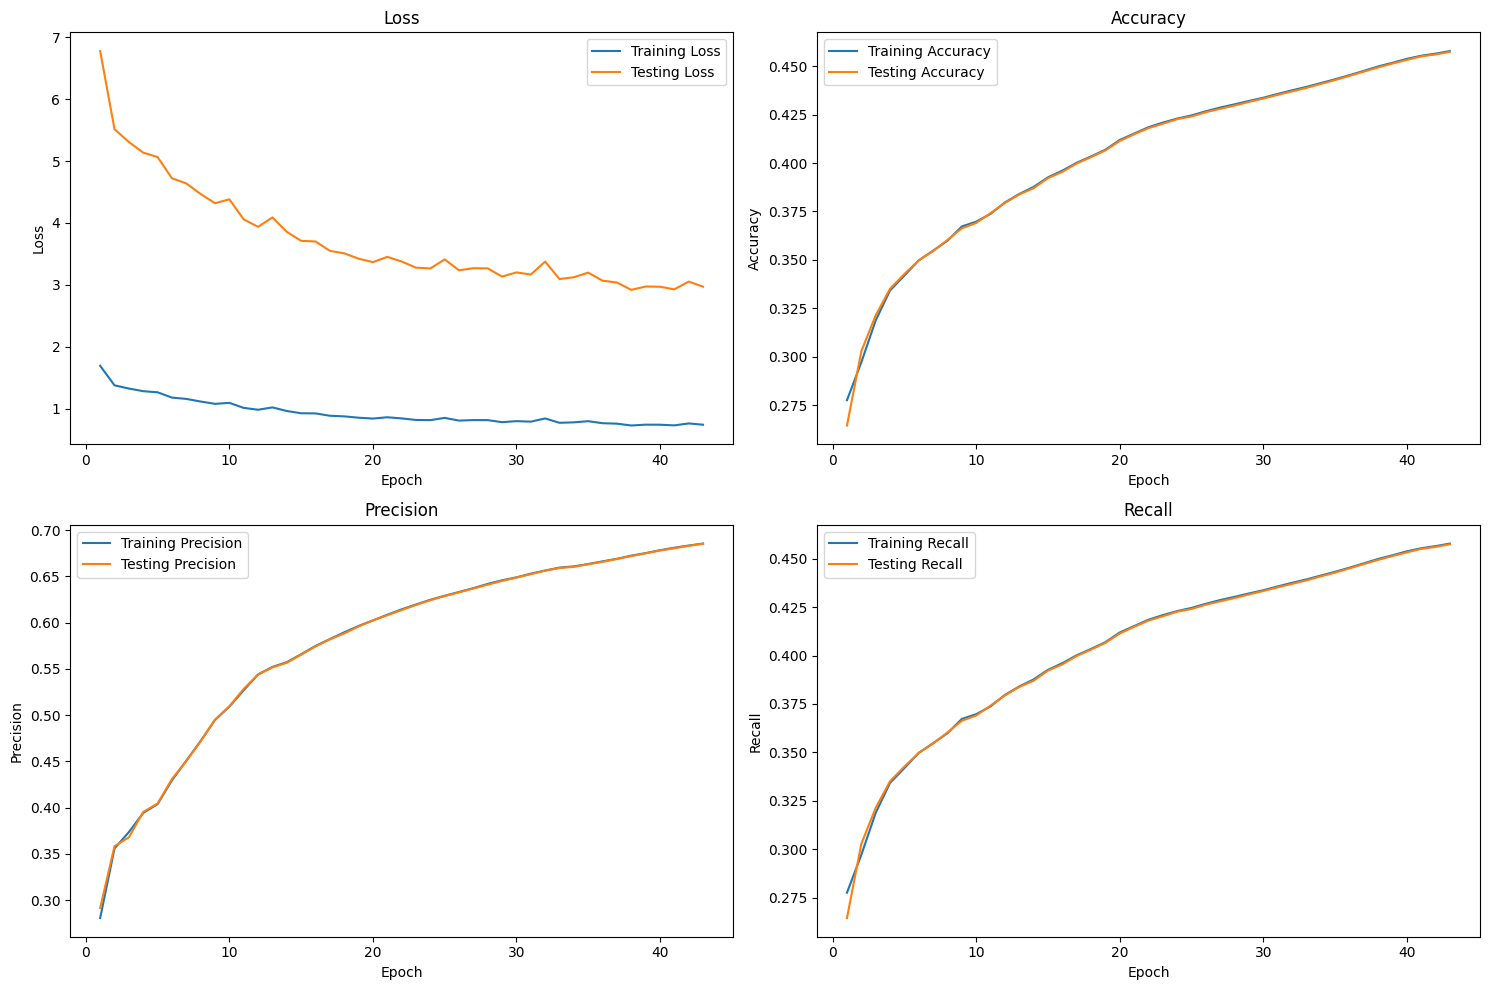

In [32]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [33]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes


### VGG16 con feature extraction cambio de learning rate a 0.0001(data augmentation)

In [34]:
torch.cuda.empty_cache()
num_epochs = 100
learning_rate = 0.0001
num_classes = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGGNetFeatureExtraction(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls = train_and_evaluate(model, train_dataloader_augmented, test_dataloader, criterion, optimizer, num_epochs, device, early_stopping=True, patience=5)

Training Epoch 1/100: 100%|████████████████| 160/160 [00:40<00:00,  3.91batch/s]


Training Loss: 1.3794, Training Accuracy: 0.2887, Training Precision: 0.3098, Training Recall: 0.2887


Testing Epoch 1/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 5.5178, Testing Accuracy: 0.2988, Testing Precision: 0.3183, Testing Recall: 0.2988


Training Epoch 2/100: 100%|████████████████| 160/160 [00:43<00:00,  3.66batch/s]


Training Loss: 1.1561, Training Accuracy: 0.3415, Training Precision: 0.3998, Training Recall: 0.3415


Testing Epoch 2/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 4.6244, Testing Accuracy: 0.3437, Testing Precision: 0.4186, Testing Recall: 0.3437


Training Epoch 3/100: 100%|████████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 1.0149, Training Accuracy: 0.3823, Training Precision: 0.5135, Training Recall: 0.3823


Testing Epoch 3/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 4.0597, Testing Accuracy: 0.3859, Testing Precision: 0.5095, Testing Recall: 0.3859


Training Epoch 4/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.8497, Training Accuracy: 0.4216, Training Precision: 0.5750, Training Recall: 0.4216


Testing Epoch 4/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.41batch/s]


Testing Loss: 3.3988, Testing Accuracy: 0.4208, Testing Precision: 0.5743, Testing Recall: 0.4208


Training Epoch 5/100: 100%|████████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.6826, Training Accuracy: 0.4585, Training Precision: 0.6262, Training Recall: 0.4585


Testing Epoch 5/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 2.7302, Testing Accuracy: 0.4581, Testing Precision: 0.6257, Testing Recall: 0.4581


Training Epoch 6/100: 100%|████████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.5299, Training Accuracy: 0.4955, Training Precision: 0.6746, Training Recall: 0.4955


Testing Epoch 6/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.32batch/s]


Testing Loss: 2.1197, Testing Accuracy: 0.4935, Testing Precision: 0.6716, Testing Recall: 0.4935


Training Epoch 7/100: 100%|████████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.4163, Training Accuracy: 0.5305, Training Precision: 0.7137, Training Recall: 0.5305


Testing Epoch 7/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.36batch/s]


Testing Loss: 1.6653, Testing Accuracy: 0.5267, Testing Precision: 0.7069, Testing Recall: 0.5267


Training Epoch 8/100: 100%|████████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.3234, Training Accuracy: 0.5594, Training Precision: 0.7380, Training Recall: 0.5594


Testing Epoch 8/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 1.2937, Testing Accuracy: 0.5558, Testing Precision: 0.7354, Testing Recall: 0.5558


Training Epoch 9/100: 100%|████████████████| 160/160 [00:41<00:00,  3.83batch/s]


Training Loss: 0.2442, Training Accuracy: 0.5864, Training Precision: 0.7612, Training Recall: 0.5864


Testing Epoch 9/100: 100%|███████████████████| 40/40 [00:09<00:00,  4.37batch/s]


Testing Loss: 0.9770, Testing Accuracy: 0.5831, Testing Precision: 0.7585, Testing Recall: 0.5831


Training Epoch 10/100: 100%|███████████████| 160/160 [00:41<00:00,  3.86batch/s]


Training Loss: 0.1595, Training Accuracy: 0.6122, Training Precision: 0.7814, Training Recall: 0.6122


Testing Epoch 10/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.6382, Testing Accuracy: 0.6082, Testing Precision: 0.7771, Testing Recall: 0.6082


Training Epoch 11/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.1557, Training Accuracy: 0.6332, Training Precision: 0.7955, Training Recall: 0.6332


Testing Epoch 11/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.6226, Testing Accuracy: 0.6290, Testing Precision: 0.7927, Testing Recall: 0.6290


Training Epoch 12/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.1164, Training Accuracy: 0.6508, Training Precision: 0.8080, Training Recall: 0.6508


Testing Epoch 12/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]


Testing Loss: 0.4658, Testing Accuracy: 0.6472, Testing Precision: 0.8020, Testing Recall: 0.6472


Training Epoch 13/100: 100%|███████████████| 160/160 [00:41<00:00,  3.84batch/s]


Training Loss: 0.1057, Training Accuracy: 0.6668, Training Precision: 0.8156, Training Recall: 0.6668


Testing Epoch 13/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.42batch/s]


Testing Loss: 0.4230, Testing Accuracy: 0.6620, Testing Precision: 0.8120, Testing Recall: 0.6620


Training Epoch 14/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.1080, Training Accuracy: 0.6797, Training Precision: 0.8237, Training Recall: 0.6797


Testing Epoch 14/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.46batch/s]


Testing Loss: 0.4320, Testing Accuracy: 0.6761, Testing Precision: 0.8197, Testing Recall: 0.6761


Training Epoch 15/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.0722, Training Accuracy: 0.6917, Training Precision: 0.8301, Training Recall: 0.6917


Testing Epoch 15/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.51batch/s]


Testing Loss: 0.2889, Testing Accuracy: 0.6881, Testing Precision: 0.8271, Testing Recall: 0.6881


Training Epoch 16/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.0702, Training Accuracy: 0.7026, Training Precision: 0.8364, Training Recall: 0.7026


Testing Epoch 16/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.2808, Testing Accuracy: 0.6986, Testing Precision: 0.8347, Testing Recall: 0.6986


Training Epoch 17/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0855, Training Accuracy: 0.7110, Training Precision: 0.8422, Training Recall: 0.7110


Testing Epoch 17/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.50batch/s]


Testing Loss: 0.3421, Testing Accuracy: 0.7074, Testing Precision: 0.8403, Testing Recall: 0.7074


Training Epoch 18/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0907, Training Accuracy: 0.7189, Training Precision: 0.8472, Training Recall: 0.7189


Testing Epoch 18/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.3628, Testing Accuracy: 0.7153, Testing Precision: 0.8449, Testing Recall: 0.7153


Training Epoch 19/100: 100%|███████████████| 160/160 [00:41<00:00,  3.88batch/s]


Training Loss: 0.0706, Training Accuracy: 0.7261, Training Precision: 0.8515, Training Recall: 0.7261


Testing Epoch 19/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.2824, Testing Accuracy: 0.7227, Testing Precision: 0.8475, Testing Recall: 0.7227


Training Epoch 20/100: 100%|███████████████| 160/160 [00:41<00:00,  3.89batch/s]


Training Loss: 0.0613, Training Accuracy: 0.7326, Training Precision: 0.8534, Training Recall: 0.7326


Testing Epoch 20/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.44batch/s]


Testing Loss: 0.2453, Testing Accuracy: 0.7293, Testing Precision: 0.8511, Testing Recall: 0.7293


Training Epoch 21/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0821, Training Accuracy: 0.7385, Training Precision: 0.8563, Training Recall: 0.7385


Testing Epoch 21/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.53batch/s]


Testing Loss: 0.3284, Testing Accuracy: 0.7357, Testing Precision: 0.8528, Testing Recall: 0.7357


Training Epoch 22/100: 100%|███████████████| 160/160 [00:41<00:00,  3.90batch/s]


Training Loss: 0.0517, Training Accuracy: 0.7446, Training Precision: 0.8583, Training Recall: 0.7446


Testing Epoch 22/100: 100%|██████████████████| 40/40 [00:08<00:00,  4.47batch/s]


Testing Loss: 0.2068, Testing Accuracy: 0.7414, Testing Precision: 0.8566, Testing Recall: 0.7414


Training Epoch 23/100: 100%|███████████████| 160/160 [00:41<00:00,  3.87batch/s]


Training Loss: 0.0354, Training Accuracy: 0.7499, Training Precision: 0.8618, Training Recall: 0.7499


Testing Epoch 23/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.33batch/s]


Testing Loss: 0.1416, Testing Accuracy: 0.7470, Testing Precision: 0.8600, Testing Recall: 0.7470


Training Epoch 24/100: 100%|███████████████| 160/160 [00:42<00:00,  3.77batch/s]


Training Loss: 0.0465, Training Accuracy: 0.7549, Training Precision: 0.8649, Training Recall: 0.7549


Testing Epoch 24/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.40batch/s]


Testing Loss: 0.1861, Testing Accuracy: 0.7516, Testing Precision: 0.8637, Testing Recall: 0.7516


Training Epoch 25/100: 100%|███████████████| 160/160 [00:41<00:00,  3.82batch/s]


Training Loss: 0.1261, Training Accuracy: 0.7581, Training Precision: 0.8671, Training Recall: 0.7581


Testing Epoch 25/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.5046, Testing Accuracy: 0.7553, Testing Precision: 0.8653, Testing Recall: 0.7553


Training Epoch 26/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0924, Training Accuracy: 0.7618, Training Precision: 0.8691, Training Recall: 0.7618


Testing Epoch 26/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.3697, Testing Accuracy: 0.7590, Testing Precision: 0.8679, Testing Recall: 0.7590


Training Epoch 27/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0517, Training Accuracy: 0.7656, Training Precision: 0.8718, Training Recall: 0.7656


Testing Epoch 27/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.39batch/s]


Testing Loss: 0.2067, Testing Accuracy: 0.7628, Testing Precision: 0.8703, Testing Recall: 0.7628


Training Epoch 28/100: 100%|███████████████| 160/160 [00:41<00:00,  3.85batch/s]


Training Loss: 0.0415, Training Accuracy: 0.7692, Training Precision: 0.8740, Training Recall: 0.7692


Testing Epoch 28/100: 100%|██████████████████| 40/40 [00:09<00:00,  4.38batch/s]

Testing Loss: 0.1662, Testing Accuracy: 0.7664, Testing Precision: 0.8728, Testing Recall: 0.7664
No improvement for 5 epochs. Early stopping...


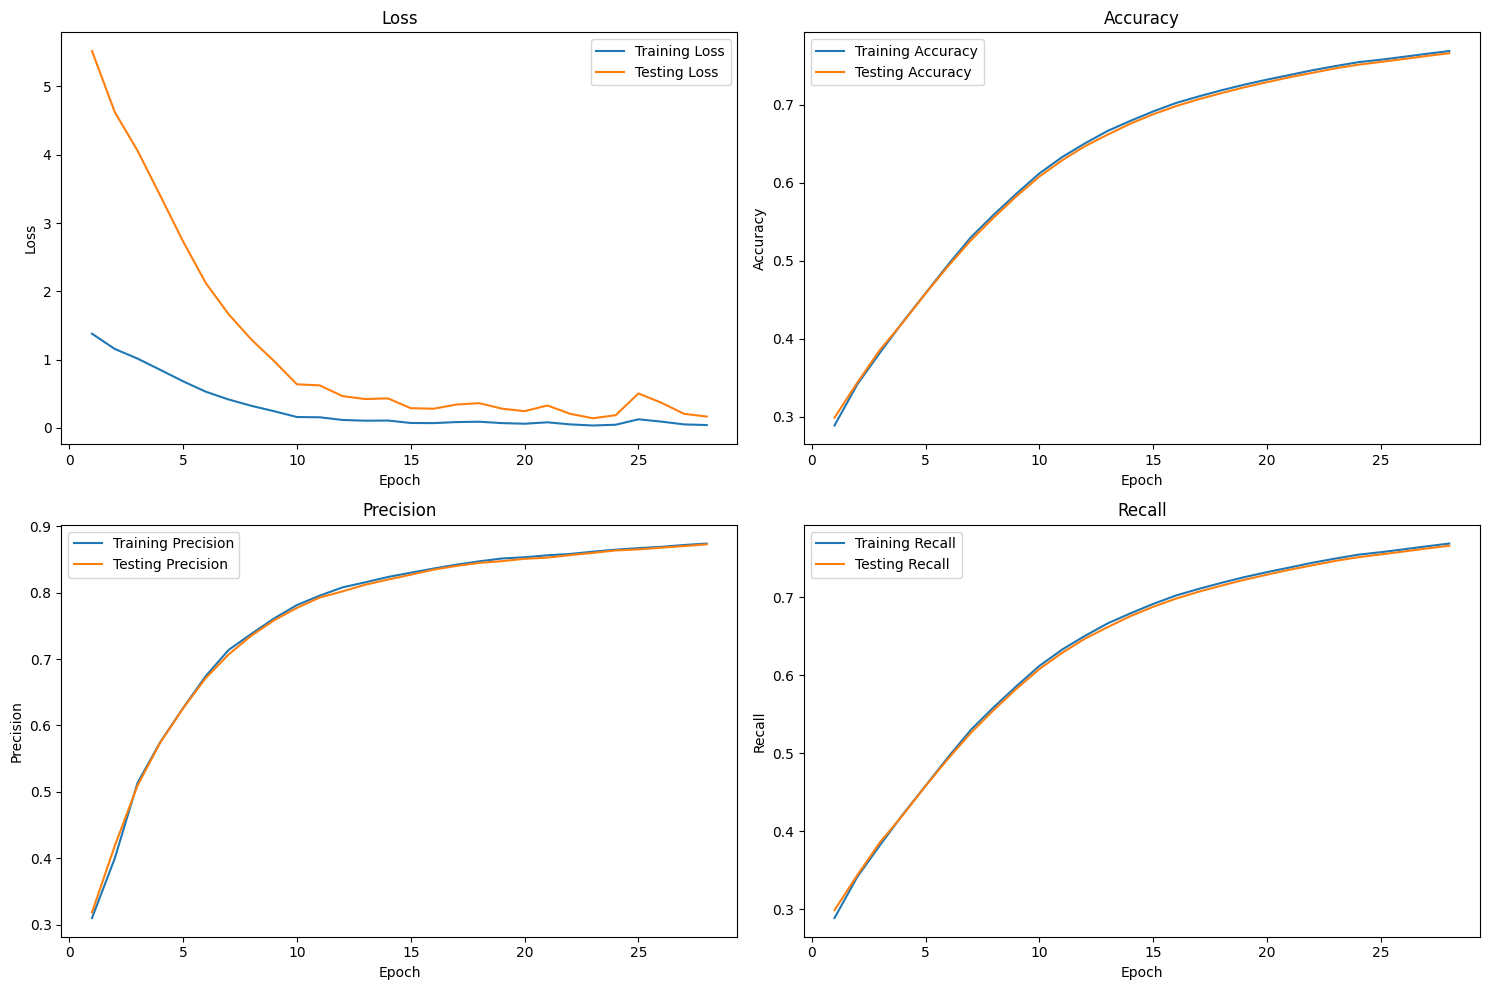

In [35]:
plot_metrics(train_losses, train_accuracies, train_precisions, train_recalls, test_losses, test_accuracies, test_precisions, test_recalls)

In [36]:
compare_predictions(model, test_dataloader, device, class_names, num_samples=20)

Expected: Diabetes, Predicted: Normal
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Normal, Predicted: Normal
Expected: Hipertensión, Predicted: Normal
Expected: Diabetes, Predicted: Otras enfermedades o anormalidades
Expected: Diabetes, Predicted: Normal
Expected: Cataratas, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Degeneración macular asociada a la edad, Predicted: Miopía
Expected: Otras enfermedades o anormalidades, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Normal, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
Expected: Diabetes, Predicted: Normal
Expected: Diabetes, Predicted: Diabetes
